In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (make_scorer,
                             roc_auc_score,
                             roc_curve,
                             f1_score,
                             recall_score,
                             precision_score,
                             precision_recall_curve,
                             classification_report,
                             plot_confusion_matrix,
                             plot_roc_curve)
import matplotlib.pyplot as plt
%matplotlib inline

seed = 36

In [ ]:
train = pd.read_csv('../data/notebook_produced_3/train.csv')

train.head()

In [ ]:
X = train.drop(columns='y')
y = train.y

## Grid search for the best model to use

In [ ]:
# names = [
#     'logistic_reg',
#     'knn',
#     'decision_tree',
#     'random_forest',
#     'grad_boost',
#     'ada_boost'
# ]

# models = [
#     LogisticRegression(solver='saga', fit_intercept=True, max_iter=1000, random_state=seed),
#     KNeighborsClassifier(),
#     DecisionTreeClassifier(random_state=seed),
#     RandomForestClassifier(random_state=seed),
#     GradientBoostingClassifier(random_state=seed),
#     AdaBoostClassifier(random_state=seed)
# ]

# param_grid = [
#     {
#         'penalty': ['l1', 'l2'],
#         'C': [.1, .5, 1., 1.5, 2]
#     },
#     {
#         'n_neighbors': [1, 3, 5, 7],
#         'metric': ['manhattan', 'euclidean', 'jaccard']
#     },
#     {
#         'criterion': ['gini', 'entropy'],
#         'max_depth': [5, 15, 30, None]
#     },
#     {
#         'n_estimators': [100, 200, 300],
#         'criterion': ['gini', 'entropy'],
#         'max_depth': [30, 50, None]
#     },
#     {
#         'learning_rate': [.1, .5, 1.],
#         'n_estimators': [300, 500],
#         'max_depth': [3, 8]
#     },
#     {
#         'n_estimators': [10, 50, 100],
#         'learning_rate': [.5, 1., 1.5]
#     }
# ]

# for name, model, params in zip(names, models, param_grid):
#     clf = GridSearchCV(
#                 model,
#                 params,
#                 scoring='roc_auc',
#                 cv=5,
#                 n_jobs=-1
#             )
#     clf.fit(X, y)
#     print(name)
#     print(clf.best_score_)
#     print(clf.best_params_)
#     print('------------------------------')

In [ ]:
# logistic_reg
# 0.7543330036010423
# {'C': 0.1, 'penalty': 'l2'}
# ------------------------------
# knn
# 0.7914429160608701
# {'metric': 'manhattan', 'n_neighbors': 7}
# ------------------------------
# decision_tree
# 0.8378912734108533
# {'criterion': 'entropy', 'max_depth': 30}
# ------------------------------
# random_forest
# 0.8460280605880222
# {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 200}
# ------------------------------
# grad_boost
# 0.8520771463668148
# {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}
# ------------------------------
# ada_boost
# 0.8054061181008842
# {'learning_rate': 1.5, 'n_estimators': 100}
# ------------------------------

In [ ]:
def tp_tn_fn_fp(true_value, predicted_value):
    tp, tn, fn, fp = 0, 0, 0, 0
    for v, p in zip(true_value, predicted_value):
        if v == p:
            if v+p == 2: tp += 1
            else: tn += 1
        elif v == 1: fn += 1
        else: fp += 1
    return tp, tn, fn, fp

def lift_score(true_value, predicted_value):
    tp, tn, fn, fp = tp_tn_fn_fp(true_value, predicted_value)
    return ( tp/(tp+fp) ) / ( (tp+fn) / (tp+tn+fp+fn) )

lift_scorer = make_scorer(lift_score)

In [ ]:
models = [
    RandomForestClassifier(random_state=seed)
]

param_grid = [
    {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [30, 50, None]
    }
]


clf = GridSearchCV(
            models[0],
            param_grid[0],
            scoring='roc_auc',
#             scoring={
#                 'roc_auc': make_scorer(roc_auc_score),
#                 'lift_score': lift_scorer
#             },
            cv=5,
            n_jobs=-1
        )
clf.fit(X, y)

print(clf.best_score_)
print(clf.best_params_)

# models = [
#     RandomForestClassifier(random_state=seed)
# ]

# param_grid = [
#     {
#         'n_estimators': [100, 200, 300],
#         'criterion': ['gini', 'entropy'],
#         'max_depth': [30, 50, None]
#     }
# ]


# clf = GridSearchCV(
#             models[0],
#             param_grid[0],
# #             scoring='roc_auc',
#             scoring={
#                 'roc_auc': make_scorer(roc_auc_score),
# #                 'lift_score': lift_scorer
#             },
#             cv=5,
#             n_jobs=-1,
#             refit='roc_auc'
#         )
# clf.fit(X, y)

# print(clf.best_score_)
# print(clf.best_params_)

In [ ]:
r = clf.cv_results_
for i in r.keys():
    print(i)

In [ ]:
print(classification_report(y, clf.predict(X)))

# holdout data

In [2]:
test = pd.read_csv('../data/notebook_produced_3/test.csv')

test.head()

,y,job_retired,job_student,default_unknown,contact_cellular,contact_telephone,month_dec,month_mar,month_may,month_oct,month_sep,poutcome_success,pdays,previous,emp_var_rate,euribor3m,nr_employed,cons_price_idx,cons_conf_idx
0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1.1,4.857,5191.0,0.93994,-36.4
1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1.1,4.857,5191.0,0.93994,-36.4
2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1.1,4.857,5191.0,0.93994,-36.4
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1.1,4.857,5191.0,0.93994,-36.4
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1.1,4.857,5191.0,0.93994,-36.4


In [3]:
X_holdout = test.drop(columns='y')
y_holdout = test.y

In [6]:
print(classification_report(y_holdout, clf.predict(X_holdout)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     10964
           1       0.37      0.45      0.41      1392

    accuracy                           0.85     12356
   macro avg       0.65      0.68      0.66     12356
weighted avg       0.87      0.85      0.86     12356



In [ ]:
clf.score(X_holdout, y_holdout), roc_auc_score(y_holdout, clf.predict(X_holdout))

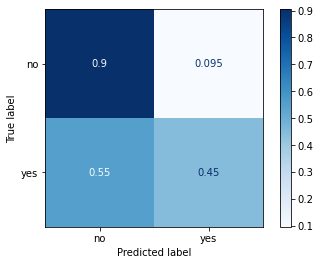

In [75]:
plot_confusion_matrix(clf, X_holdout, y_holdout,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true'
                     );

In [ ]:
lift_score(y_holdout, clf.predict(X_holdout))

In [4]:
import joblib

In [ ]:
joblib.dump(clf, '../saved_models/random_forest_feature_selected.joblib')

In [5]:
clf = joblib.load('../saved_models/random_forest_feature_selected.joblib')

In [ ]:
lift_score(y_holdout, clf.predict(X_holdout))

In [ ]:
clf.predict(X_holdout)

In [9]:
from sklearn.metrics import confusion_matrix

In [40]:
cm = confusion_matrix(y_holdout, clf.predict(X_holdout))
cm = pd.DataFrame(cm, columns=['no', 'yes'], index=['no', 'yes'])
cm.columns.name = 'Predicted'
cm.index.name = 'True'

cm_norm = (cm.T/cm.T.sum()).T

cm

Predicted,no,yes
True,,
no,9917,1047
yes,768,624


In [59]:
import plotly.express as px
import plotly.figure_factory as ff

In [74]:
# fig = px.imshow(cm_norm)
# fig.show()

In [93]:
cm_norm.round(3)

Predicted,no,yes
True,,
no,0.905,0.095
yes,0.552,0.448


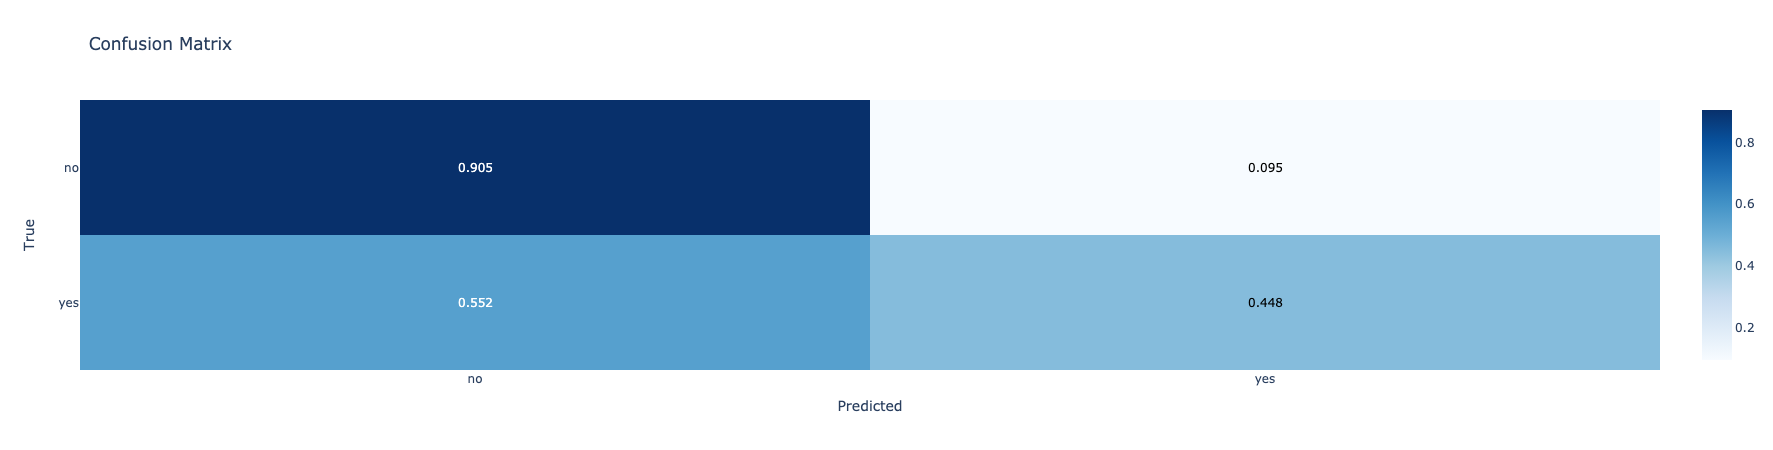

In [94]:
import plotly.graph_objs as go
import plotly.figure_factory as ff

visitors_array = cm_norm.round(3).to_numpy()[::-1, :]

#display(nparray)
Weekdays_list = ['no', 'yes'] 
Hours_list = ['yes', 'no']

layout_heatmap = go.Layout(
    title=('Confusion Matrix'),
    xaxis=dict(title='Predicted'), 
    yaxis=dict(title='True', dtick=1)
)

ff_fig = ff.create_annotated_heatmap(x= Weekdays_list, y=Hours_list, z=visitors_array, showscale = True, colorscale='Blues')
fig  = go.FigureWidget(ff_fig)
fig.layout=layout_heatmap
fig.layout.annotations = ff_fig.layout.annotations
fig.data[0].colorbar = dict(title='', titleside = 'right')

fig.show()

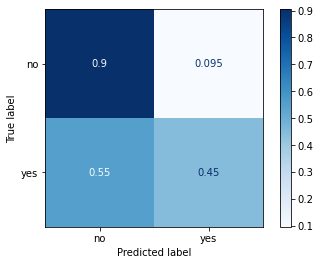

In [76]:
plot_confusion_matrix(clf, X_holdout, y_holdout,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true'
                     );

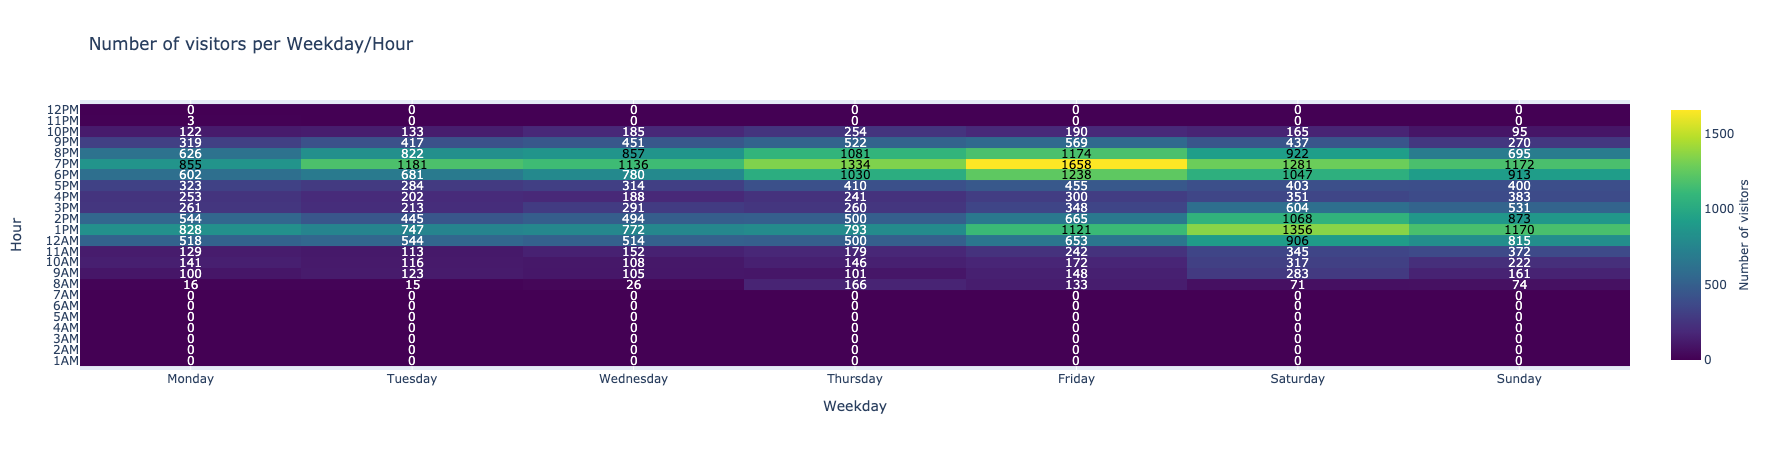

In [80]:
visitors_array=np.array([[ 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0],
[ 16, 15, 26, 166, 133, 71, 74],
[ 100, 123, 105, 101, 148, 283, 161],
[ 141, 116, 108, 146, 172, 317, 222],
[ 129, 113, 152, 179, 242, 345, 372],
[ 518, 544, 514, 500, 653, 906, 815],
[ 828, 747, 772, 793, 1121, 1356, 1170],
[ 544, 445, 494, 500, 665, 1068, 873],
[ 261, 213, 291, 260, 348, 604, 531],
[ 253, 202, 188, 241, 300, 351, 383],
[ 323, 284, 314, 410, 455, 403, 400],
[ 602, 681, 780, 1030, 1238, 1047, 913],
[ 855, 1181, 1136, 1334, 1658, 1281, 1172],
[ 626, 822, 857, 1081, 1174, 922, 695],
[ 319, 417, 451, 522, 569, 437, 270],
[ 122, 133, 185, 254, 190, 165, 95],
[ 3, 0, 0, 0, 0, 0, 0],
[ 0, 0, 0, 0, 0, 0, 0]], dtype=np.int16)

#display(nparray)
Weekdays_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # Order may be different
Hours_list = ['{:d}AM'.format(i+1) for i in range(12)] + ['{:d}PM'.format(i+1) for i in range(12)]

layout_heatmap = go.Layout(
    title=('Number of visitors per Weekday/Hour'),
    xaxis=dict(title='Weekday'), 
    yaxis=dict(title='Hour', dtick=1)
)

ff_fig = ff.create_annotated_heatmap(x= Weekdays_list, y=Hours_list, z=visitors_array, showscale = True, colorscale='Viridis')
fig  = go.FigureWidget(ff_fig)
fig.layout=layout_heatmap
fig.layout.annotations = ff_fig.layout.annotations
fig.data[0].colorbar = dict(title='Number of visitors', titleside = 'right')
fig.show()